In [1]:
# this notebook looks at attention (KQ) weights to visualize how model heads
# are connecting (attending) different tokens in the context window.
# we look at the final layer because it's the most important for 
# next token generation

In [14]:
import torch
import tiktoken
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager

from llm_e2e.model import GPT2Model, MultiHeadAttention
from llm_e2e.config import GPT2Config

class AttentionVisualizer:
    def __init__(self, model: GPT2Model, encoding: tiktoken.Encoding):
        self.model = model
        self.encoding = encoding
        self._hooks = []
        self._attention_weights = []

    def _hook_fn(self, module: torch.nn.Module, inputs: tuple, output: tuple):
        # output of MultiHeadAttention is (context_vec, attn_weights)
        self._attention_weights.append(output[1].detach())

    def _register_hooks(self):
        for module in self.model.modules():
            if isinstance(module, MultiHeadAttention):
                hook = module.register_forward_hook(self._hook_fn)
                self._hooks.append(hook)

    def _remove_hooks(self):
        for hook in self._hooks:
            hook.remove()
        self._hooks = []

    @contextmanager
    def capture_attention(self):
        """a context manager to handle hook registration and removal."""
        self._register_hooks()
        try:
            yield
        finally:
            self._remove_hooks()

    def get_attention_for_prompt(self, prompt: str) -> list[torch.Tensor]:
        """
        gets attention weights for the prompt string. must be called
        within the `capture_attention` context.
        """
        if not self._hooks:
            print("no hooks registered")
            return None

        self._attention_weights = []
        self.model.eval()

        encoded_ids = self.encoding.encode(prompt)
        input_tensor = torch.tensor([encoded_ids], dtype=torch.long)

        with torch.no_grad():
            self.model(input_tensor)

        if not self._attention_weights:
            print("no attention weights captured.")
            return None

        return self._attention_weights

    def plot_attention_heads(
        self,
        attention_weights: list[torch.Tensor],
        prompt: str,
        layer_idx: int = -1,
        heads_to_show: int = 8,
        grid_dims: tuple[int, int] = (2, 4)
    ):
        """
        Plots the attention heatmaps for specified heads in a given layer.
        """
        if layer_idx < 0:
            layer_idx += len(attention_weights)

        if not 0 <= layer_idx < len(attention_weights):
            print(f"error: invalid layer index {layer_idx}. model has {len(attention_weights)} layers.")
            return

        attention_matrix = attention_weights[layer_idx]
        tokens = [self.encoding.decode([i]) for i in self.encoding.encode(prompt)]

        num_heads_available = attention_matrix.shape[1]
        heads_to_plot = min(heads_to_show, num_heads_available)

        nrows, ncols = grid_dims
        fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5.5 * nrows), squeeze=False)
        fig.suptitle(f"Attention Patterns - Layer {layer_idx + 1}", fontsize=16)

        for i, ax in enumerate(axes.flat):
            attn_head = attention_matrix[0, i, :, :].cpu().float().numpy()

            sns.heatmap(
                attn_head,
                ax=ax,
                xticklabels=tokens,
                yticklabels=tokens,
                annot=False,
                cmap='Blues',
                cbar=True
            )

            ax.set_title(f"Head {i + 1}", fontsize=12)
            ax.set_xlabel("Key Tokens", fontsize=10)
            ax.tick_params(axis='x', rotation=75, labelsize=9)
            ax.tick_params(axis='y', rotation=0, labelsize=9)

            if i == 0:
                ax.set_ylabel("Query Tokens", fontsize=10)
            else:
                ax.tick_params(axis='y', labelleft=True)
        
        fig.tight_layout(pad=1.5)
        plt.show()

loaded config from: ../config/gpt2_bert_corpus_gpu.yaml


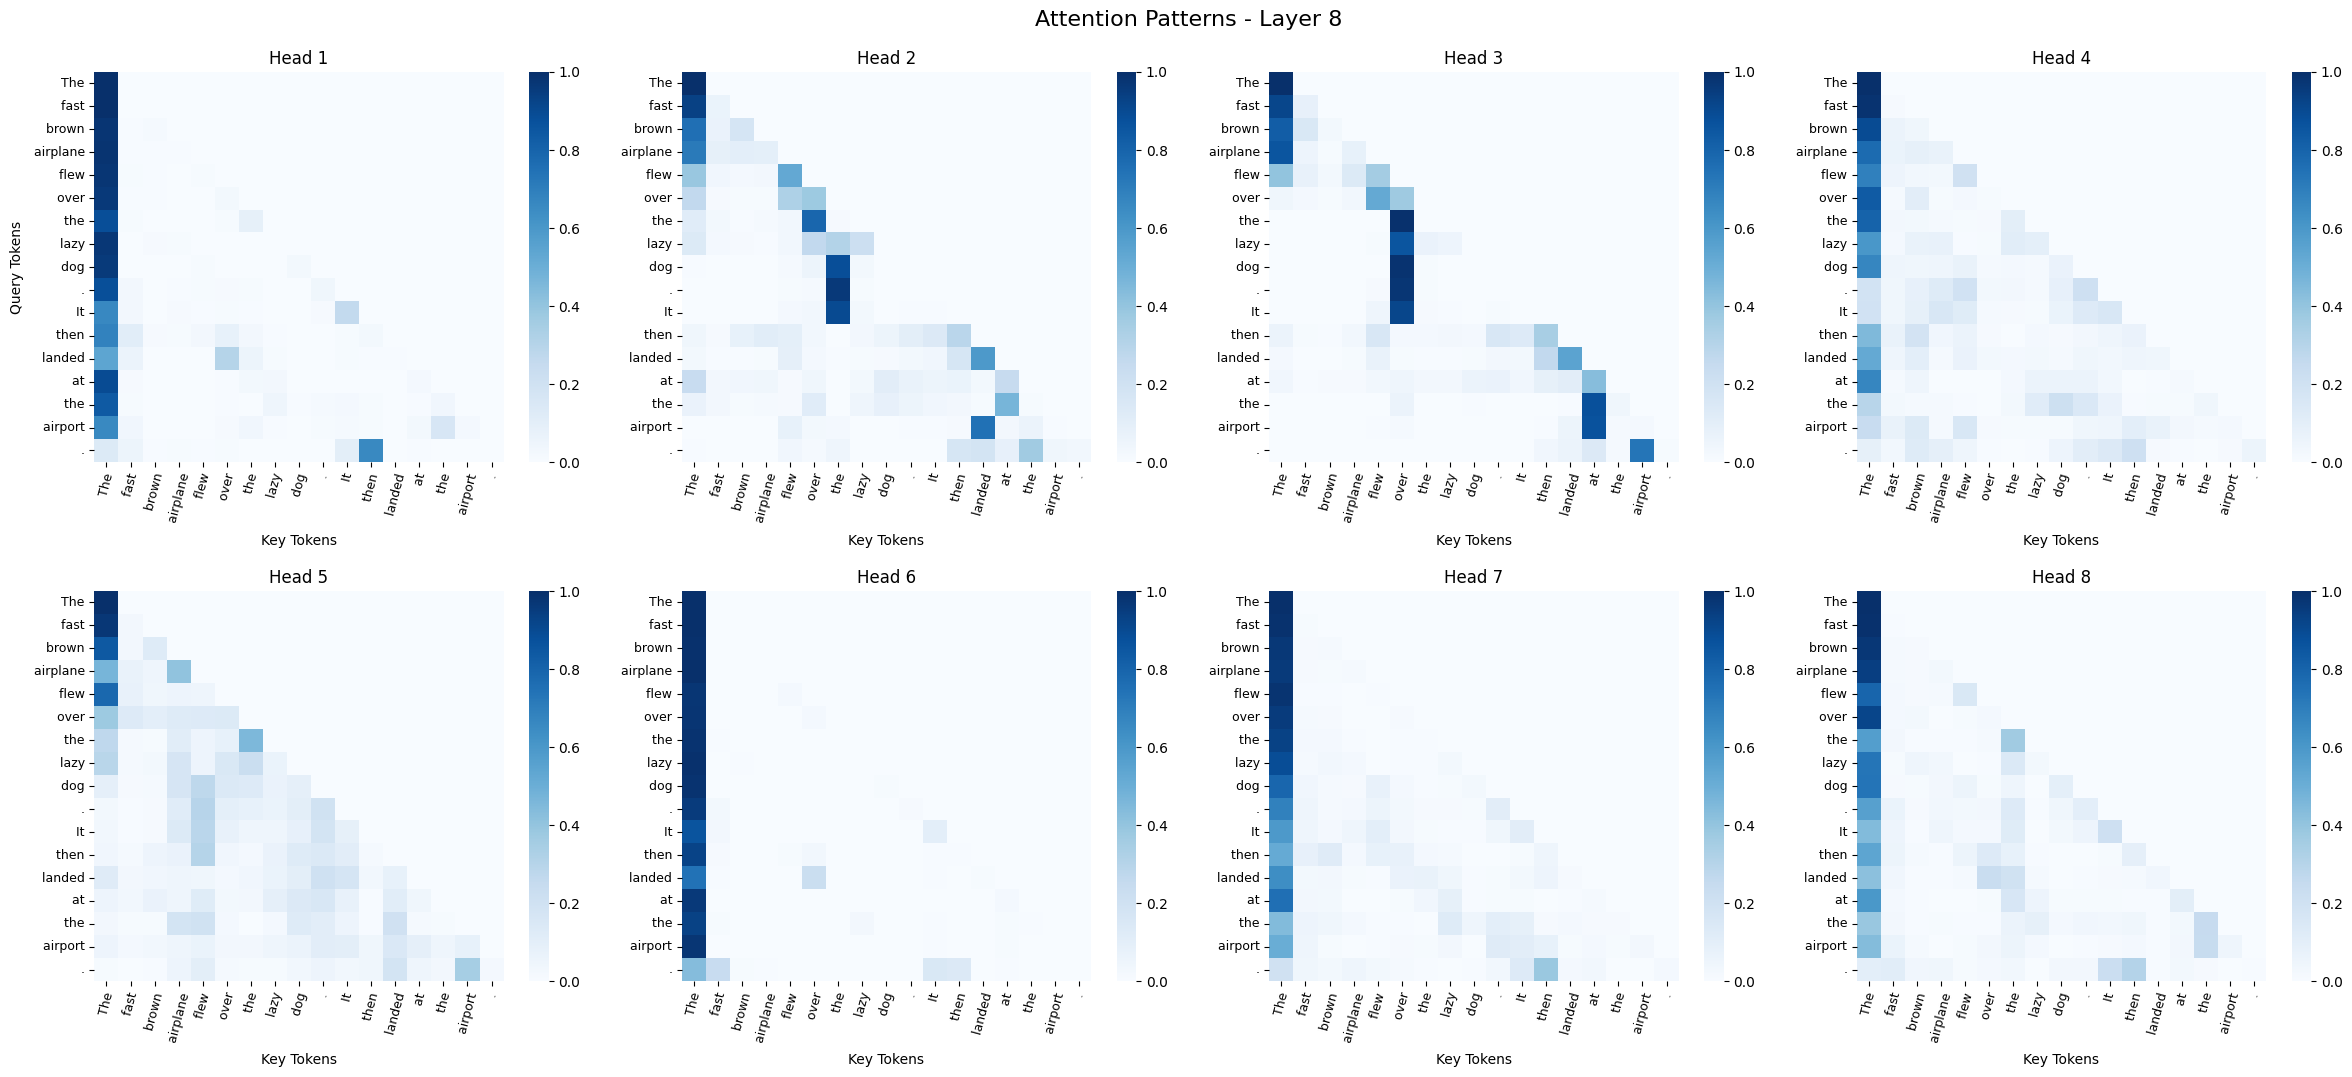

In [18]:
import torch
import tiktoken
from llm_e2e.config import GPT2Config
from llm_e2e.model import GPT2Model

cfg = GPT2Config.from_yaml('../config/gpt2_bert_corpus_gpu.yaml')
prompt = "The fast brown airplane flew over the lazy dog. It then landed at the airport."

encoding = tiktoken.get_encoding(cfg.encoding_name)

gpt_model = GPT2Model(cfg)
d = torch.load('../models/gpt_bert.pth', weights_only=True, map_location=torch.device('cpu'))
gpt_model.load_state_dict(d)

visualizer = AttentionVisualizer(gpt_model, encoding)

attention_weights = None

with visualizer.capture_attention():
    attention_weights = visualizer.get_attention_for_prompt(prompt)
    visualizer.plot_attention_heads(
            attention_weights=attention_weights,
            prompt=prompt,
            layer_idx=-1,
            heads_to_show=cfg.n_heads
        )
